In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.special as sp
import sklearn.datasets as datasets
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import econml
import importlib
import pyreadr

#### data generation packages
import strawman_edge
import strawman_center
import all_linear

#### main packages
import characterize
import estimate_atte as est
import learn_w as learn
import black

importlib.reload(est)
importlib.reload(learn)

import warnings

warnings.filterwarnings("ignore")

%load_ext jupyter_black
sns.set(font_scale=1.25, style="whitegrid")
np.random.seed(0)

## Fetching the Data

In [2]:
outcome_cols = ["opioiduse12", "opioiduse24"]
treatment_col = "medicine_assigned"
discrete_cov = ["xrace", "mar", "sex"]

baseline_harmonized = pd.read_csv(
    "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/updated_data/ctn0094/drv/clean_patients_with_relapse_wide.csv",
    index_col=0,
)

stacked_list = []
for i in range(1, 6):
    stacked_list.append(
        pd.read_csv(
            "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/stacked_list_%d.csv"
            % (i),
            index_col=0,
        )
    )
df = stacked_list[0]

df_tedsa = df.loc[df["trialdata"] == 0]

### Combining TEDS-A + CTN 27 dataset

In [3]:
np.random.seed(42)
ct94 = baseline_harmonized.loc[(baseline_harmonized["project"] == 27)]
outcome94 = ct94[outcome_cols]

common_cols = set.intersection(set(df_tedsa.columns), set(ct94.columns))

ct94_cc = ct94[common_cols].drop(columns=["edu", "mar"])
ct94_cc["sex"] = (ct94["sex"] == "male").astype(int)  # male = 1 and female = 0
# ct94_cc["mar"].loc[(1 - ct94_cc["mar"].isna()) == 1] = (ct94_cc["mar"] == 1.0).astype(
#     int
# )
# ct94_cc["edu"].loc[(1 - ct94_cc["edu"].isna()) == 1] = (ct94_cc["edu"] >= 2.0).astype(
#     int
# )

imputer = KNNImputer(n_neighbors=4, weights="distance", add_indicator=False)
ct94_cc_imputed = imputer.fit_transform(ct94_cc)

ct94_cc = pd.DataFrame(ct94_cc_imputed, index=ct94_cc.index, columns=ct94_cc.columns)

ct94_cc["med_met"] = (ct94[treatment_col] == "met").astype(
    int
)  # methadone = 1 and bupenorphine = 0
ct94_cc = ct94_cc.dropna()

ct94_cc["S"] = 1
ct94_cc = ct94_cc.round(0).astype(int)

ct94_cc = ct94_cc.join(outcome94, how="inner")
print(ct94_cc.shape)
ct94_cc.groupby(by="med_met").mean()[outcome_cols]

(1271, 11)


opioiduse12  opioiduse24
med_met                          
0           0.629380     0.750674
1           0.553875     0.650284

In [4]:
df_tedsa_cc = df_tedsa[common_cols].drop(columns=["edu", "mar"])
df_tedsa_cc["S"] = 0
# invert age categories
df_tedsa_cc["age"].replace(
    {
        1: 13,
        2: 16,
        3: 18,
        4: 22,
        5: 27,
        6: 32,
        7: 37,
        8: 42,
        9: 47,
        10: 52,
        11: 60,
        12: 68,
    },
    inplace=True,
)

# df_tedsa_cc["mar"].loc[(1 - df_tedsa_cc["mar"].isna()) == 1] = (
#     df_tedsa_cc["mar"] == 1.0
# ).astype(int)
# df_tedsa_cc["edu"].loc[(1 - df_tedsa_cc["edu"].isna()) == 1] = (
#     df_tedsa_cc["edu"] >= 2.0
# ).astype(int)

In [5]:
df_primary = pd.concat([df_tedsa_cc.sample(frac=1, replace=False), ct94_cc])

df_ = df_primary.drop(columns=[outcome_cols[0]]).fillna(0)

In [34]:
outcome = outcome_cols[1]
treatment = "med_met"
sample = "S"
data = df_
S = df_[sample]  # indicator for the sample
Y = df_[outcome]  # outcome variable
T = df_[treatment]  # indicator for the treatment

data_dummy = pd.get_dummies(data, columns=["xrace"])
data_dummy.rename(
    columns={
        "sex": "Male",
        "age": "Age",
        "ivdrug": "IV Drug Use",
        "bamphetamine30_base": "Hx Amphetamine",
        "bbenzo30_base": "Hx Benzo",
        "bcannabis30_base": "Hx Cannabis",
        "xrace_1": "White",
        "xrace_2": "Black",
        "xrace_3": "Hispanic",
        "xrace_4": "Other Race",
    },
    inplace=True,
)

X = data_dummy.drop(columns=[outcome, treatment, sample])  # pre-treatment covariates

latex_table = data_dummy.groupby(by=[sample]).mean().T.round(4).to_latex()
X.columns

Index(['Age', 'IV Drug Use', 'Hx Amphetamine', 'Male', 'Hx Cannabis',
       'Hx Benzo', 'White', 'Black', 'Hispanic', 'Other Race'],
      dtype='object')

## Estimate RCT-ATE and Target-ATE

In [7]:
importlib.reload(learn)
np.random.seed(42)
df_v, pi, pi_m, e_m, data2 = learn.estimate_ipw(data_dummy, outcome, treatment, sample)

In [8]:
print(
    "RCT-ATE: %.2f ± %.2f"
    % (
        100
        * (
            df_.loc[(df_[sample] == 1) * (df_[treatment] == 1), outcome].mean()
            - df_.loc[(df_[sample] == 1) * (df_[treatment] == 0), outcome].mean()
        ),
        100
        * (
            df_.loc[(df_[sample] == 1) * (df_[treatment] == 1), outcome].sem()
            + df_.loc[(df_[sample] == 1) * (df_[treatment] == 0), outcome].sem()
        ),
    )
)


print(
    "Transported ATE: %.2f ± %.2f" % (100 * df_v["te"].mean(), 100 * df_v["te"].sem())
)

RCT-ATE: -10.04 ± 3.66
Transported ATE: -9.72 ± 4.68


## Characterizing Underrepresented Population via Selection Score

In [9]:
np.random.seed(42)
data_dummy_logit = data_dummy.copy(deep=True)
data_dummy_logit["pi(x)"] = pi_m.predict_proba(X)[:, 1]
data_dummy_logit["pi(x)/pi"] = data_dummy_logit["pi(x)"] / data_dummy_logit["S"].mean()
# exp_te_m = en.AdaBoostRegressor().fit(data2[X.drop(columns=["Age"]).columns], df_v["a"])

data_dummy_logit["pi(x)/pi"] = data_dummy_logit["pi(x)"] / data_dummy_logit["S"].mean()

### Plotting selection scores per study samples

S              0.001715
med_met        0.000714
opioiduse24    0.001215
pi(x)          0.001715
pi(x)/pi       1.000282
dtype: float64

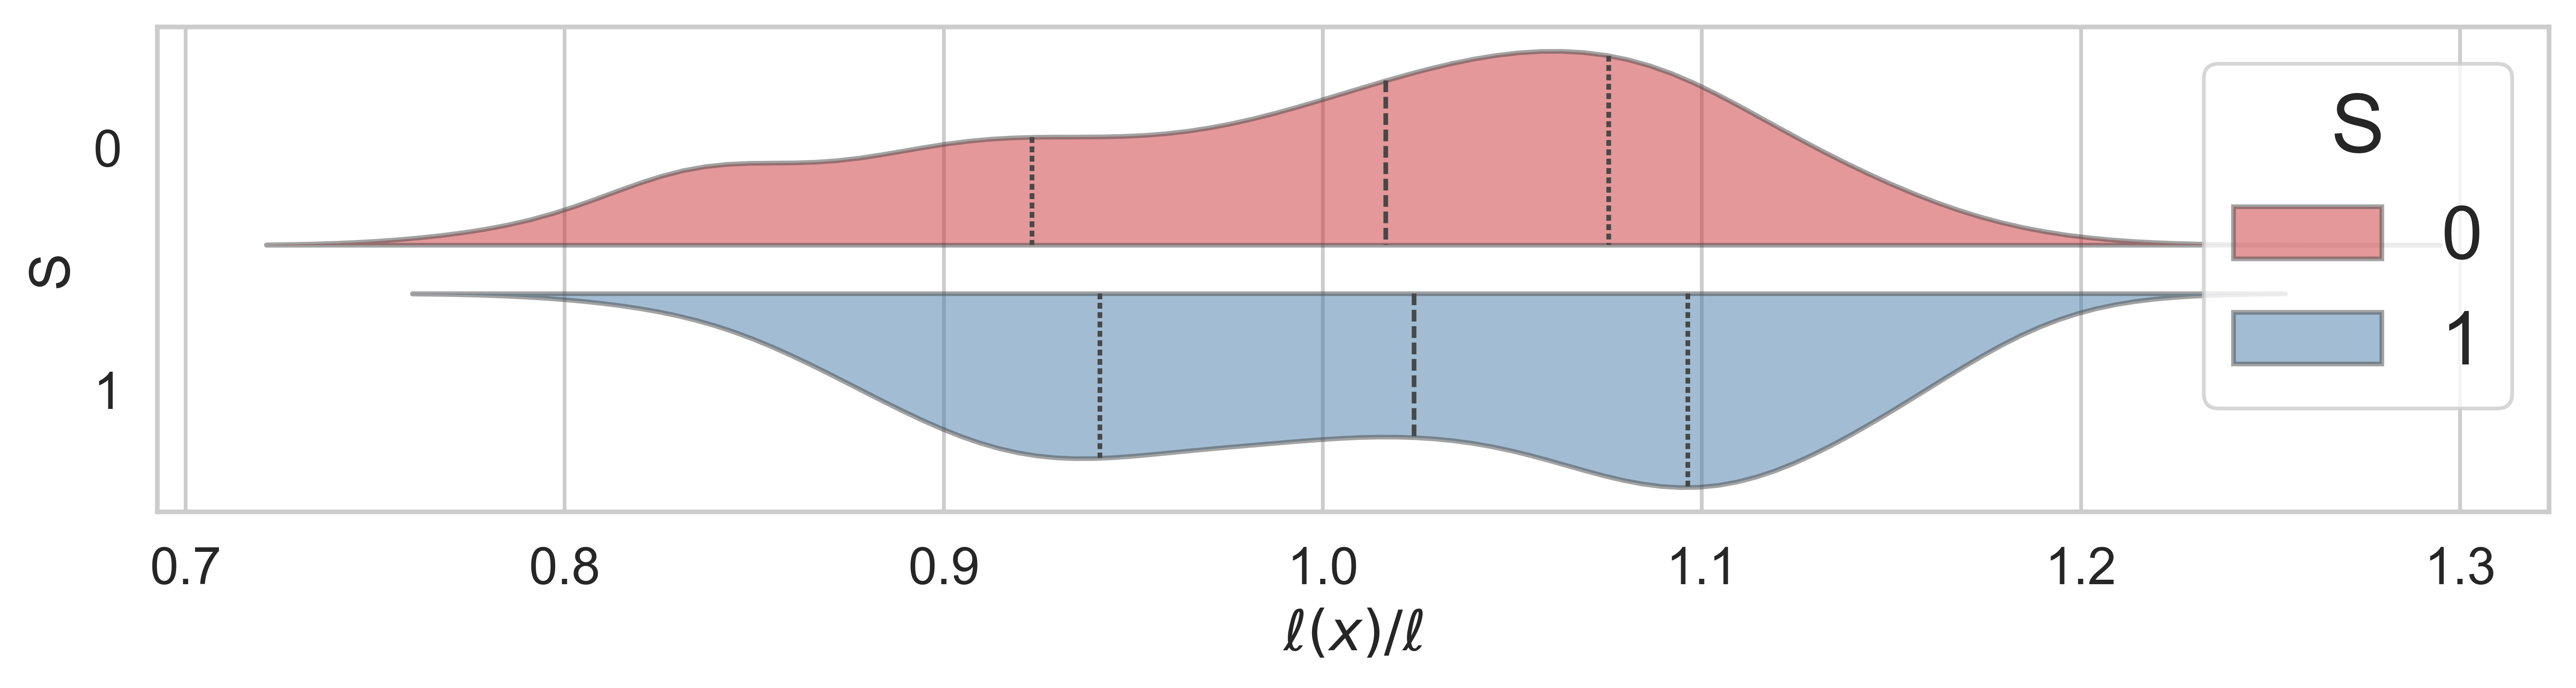

In [10]:
fig, ax = plt.subplots(sharex=True, figsize=(10, 3), dpi=600)
sns.set(font_scale=1.8, style="whitegrid")
sns.violinplot(
    data=data_dummy_logit,
    x="pi(x)/pi",
    y="S",
    hue="S",
    split=True,
    orient="h",
    ax=ax,
    alpha=0.5,
    inner="quart",
    bw=0.25,
    palette="Set1",
)
plt.xlabel(r"$\ell(x)/{\ell}$")
plt.tight_layout()
plt.savefig("selection_logit.pdf")

# sns.set(font_scale=1.8, style="whitegrid")
# fig, ax = plt.subplots(sharex=True, figsize=(10, 3), dpi=600)
# sns.violinplot(
#     data=data_dummy_logit,
#     y="S",
#     hue="S",
#     x="pi(x)/pi",
#     orient="h",
#     split="True",
#     inner="quart",
#     alpha=0.5,
#     bw=0.25,
# )
# plt.axvline(0.865, c="black", ls="--")
# plt.xlabel(r"$\ell(x)/\overline{\ell}$")

data_dummy_logit = data_dummy_logit.drop(columns=X.columns, errors="ignore")
data_dummy_logit.mean()

### Ad-hoc $w(x) = ( \ell(x)/\ell > 0.87 )$

Post Pruning, ATTE: -9.222 ± 4.750


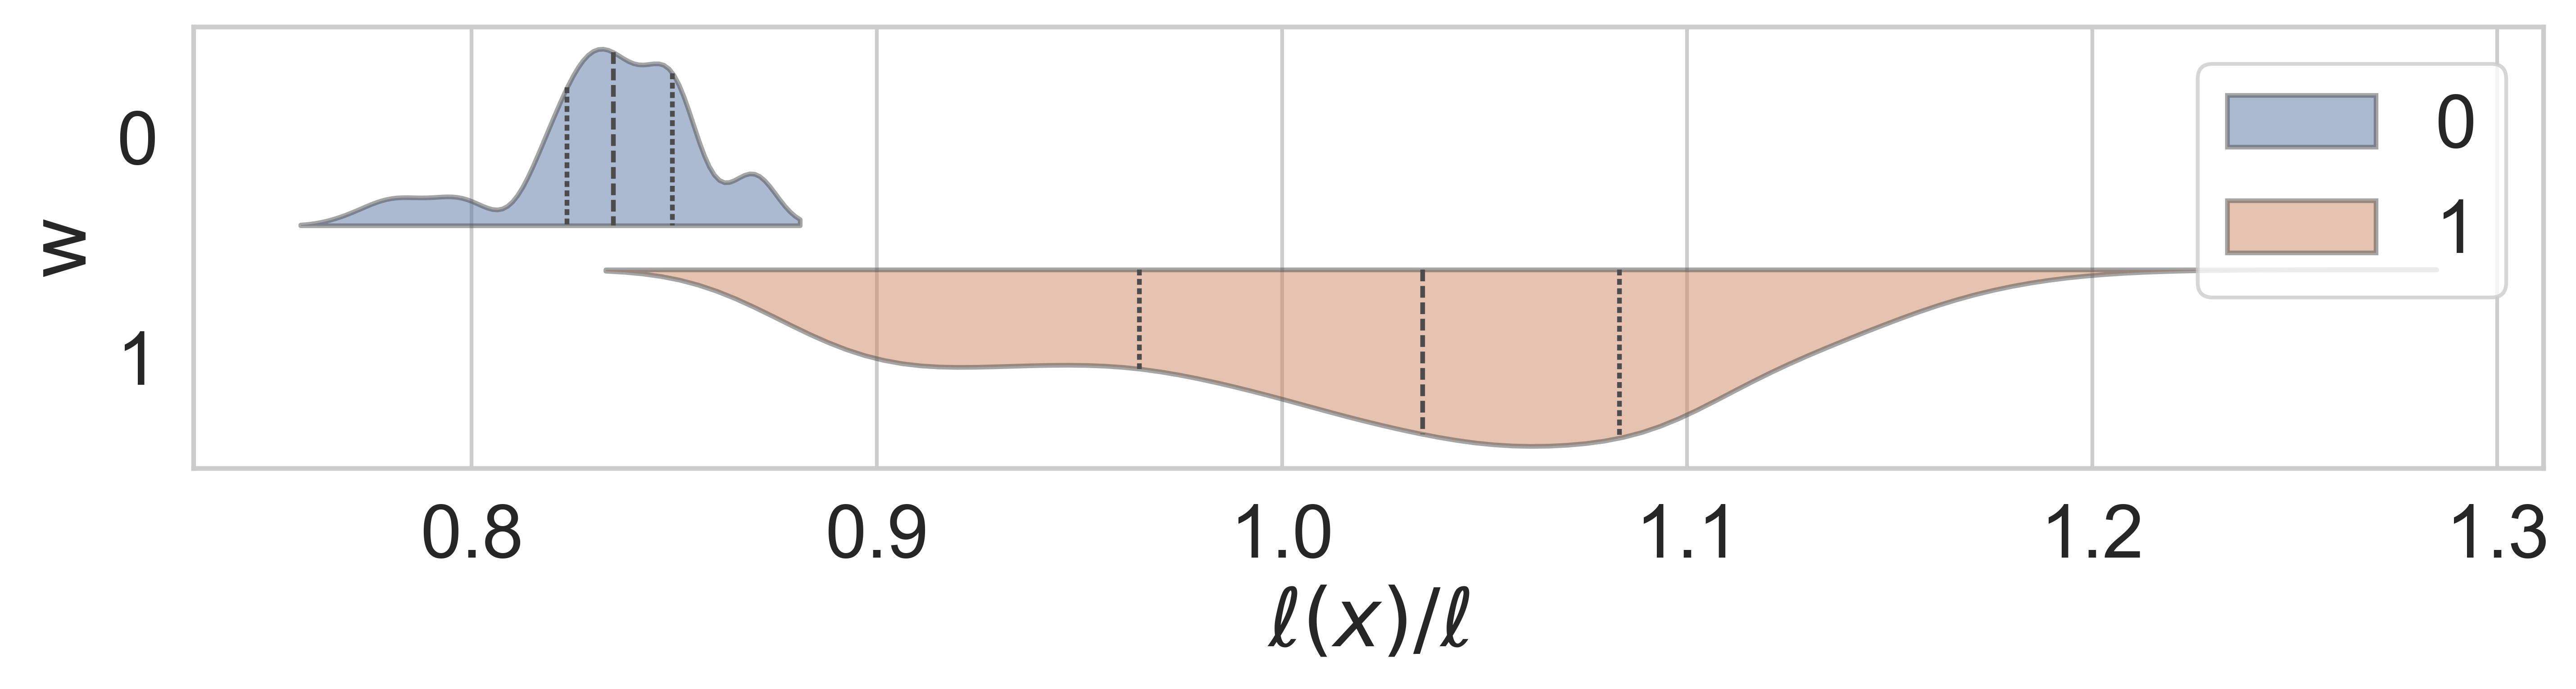

In [11]:
data_dummy_logit["w (predefined threshold)"] = (
    (
        (data_dummy_logit["pi(x)"] / S.mean())
        / ((1 - data_dummy_logit["pi(x)"]) / (1 - S.mean()))
    )
    > 0.87
).astype(int)
data_dummy_logit.mean()

print(
    r"Post Pruning, ATTE: %.3f ± %.3f"
    % (
        100 * df_v["te"].loc[data_dummy_logit["w (predefined threshold)"] == 1].mean(),
        100 * df_v["te"].loc[data_dummy_logit["w (predefined threshold)"] == 1].sem(),
    )
)

data_dummy_logit["pi(x)/pi"] = data_dummy_logit["pi(x)"] / data_dummy_logit["S"].mean()
fig, ax = plt.subplots(sharex=True, figsize=(10, 3), dpi=600)
sns.set(font_scale=1.8, style="whitegrid")
sns.violinplot(
    data=data_dummy_logit,
    x="pi(x)/pi",
    y="w (predefined threshold)",
    hue="w (predefined threshold)",
    split=True,
    orient="h",
    ax=ax,
    alpha=0.5,
    inner="quart",
    bw=0.25,
)
plt.xlabel(r"$\ell(x)/{\ell}$")
plt.ylabel("w")
plt.legend()
plt.tight_layout()
plt.savefig("underrep_logit_adhoc.pdf")

### Optimized Selection Score $w(x)$

(0.8339547909581916, 4.675565619888205, 0.991345397324941)

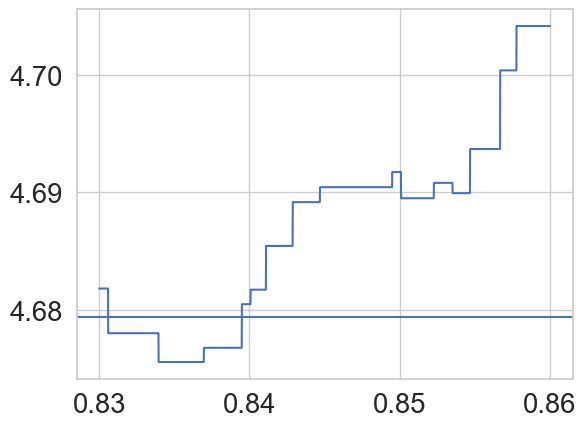

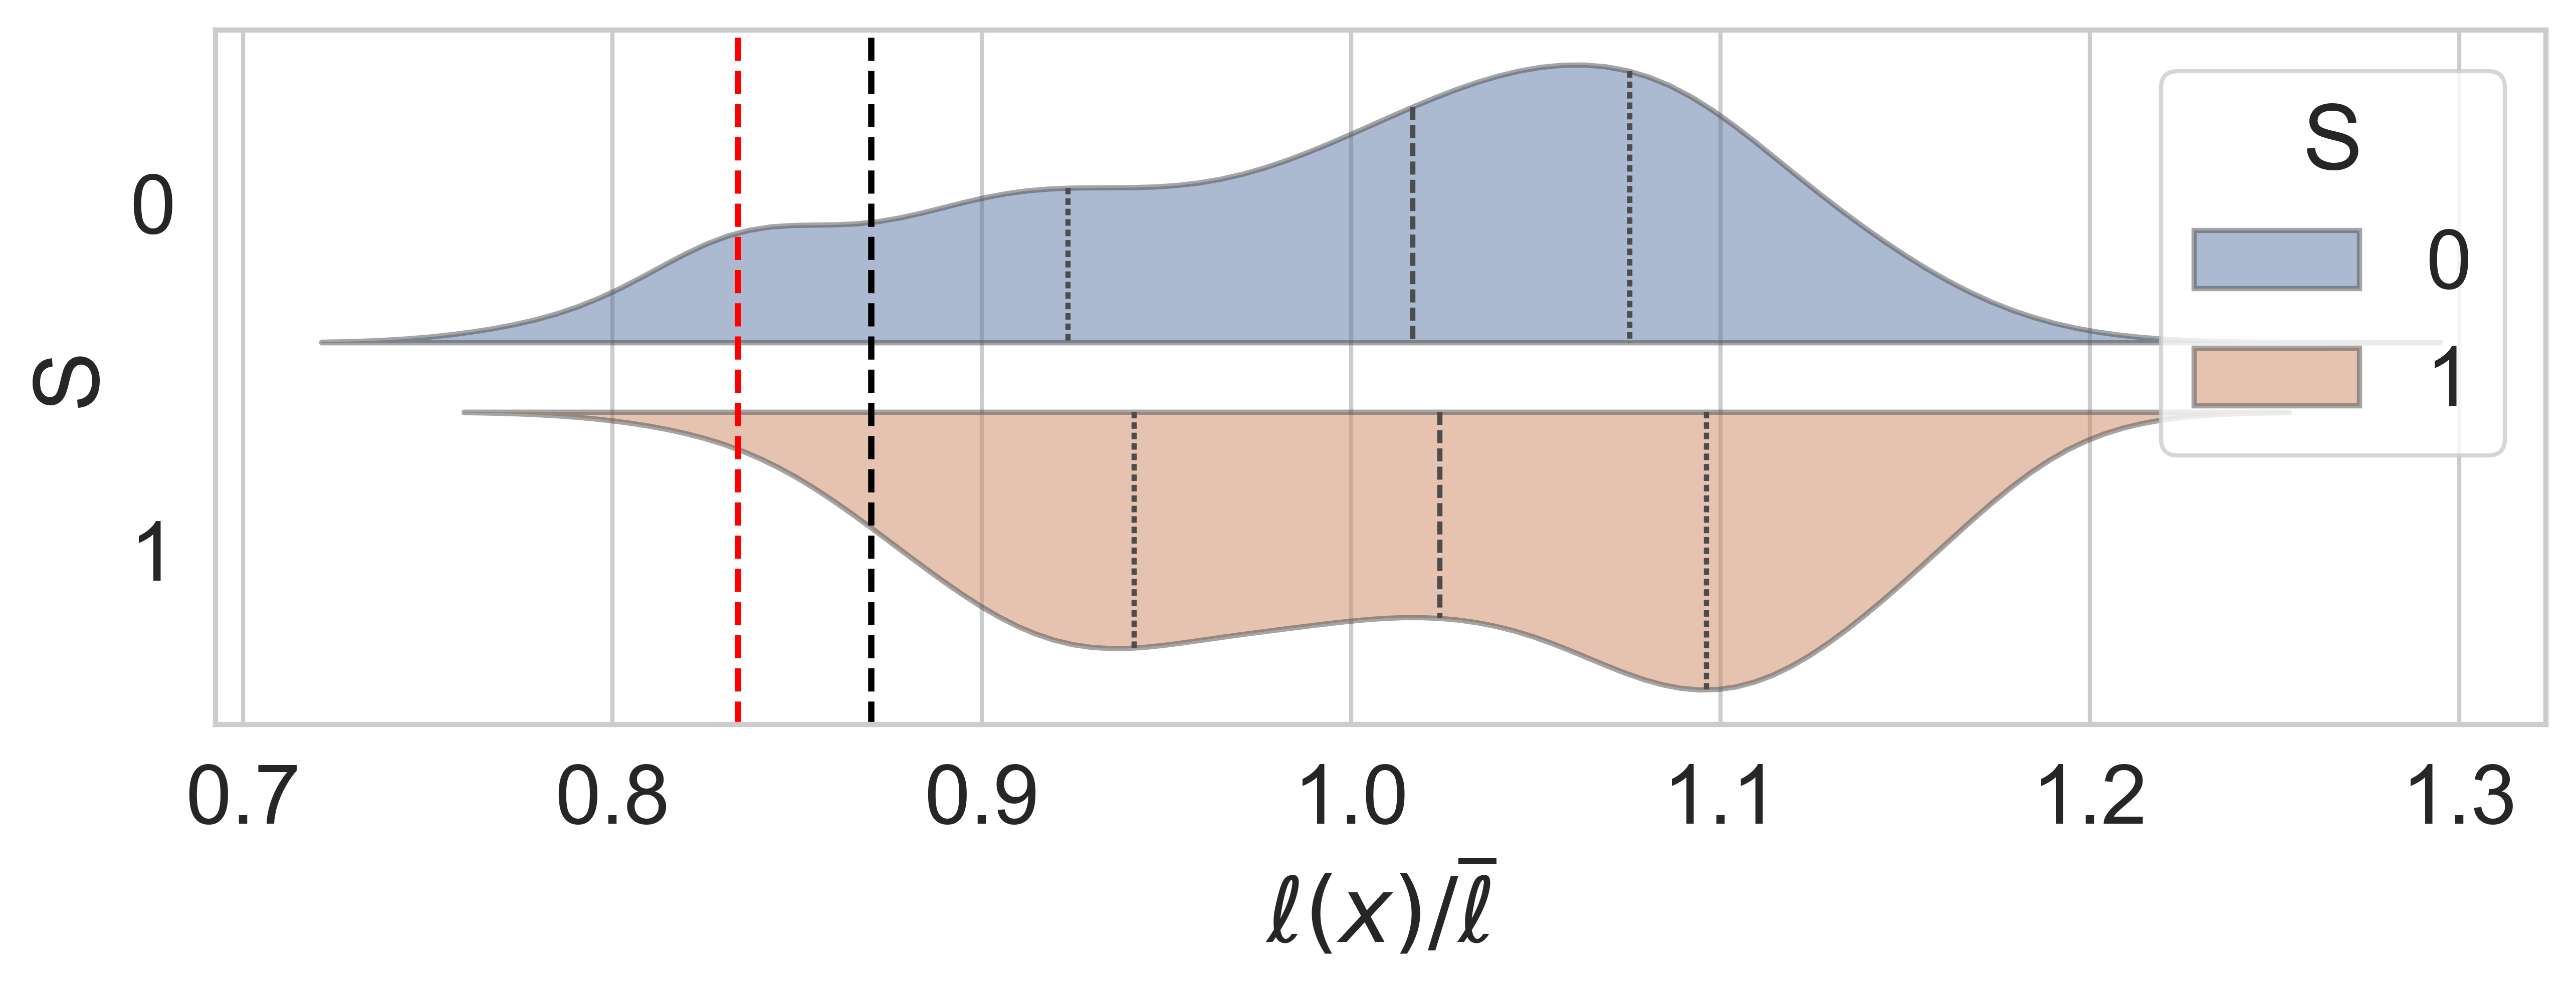

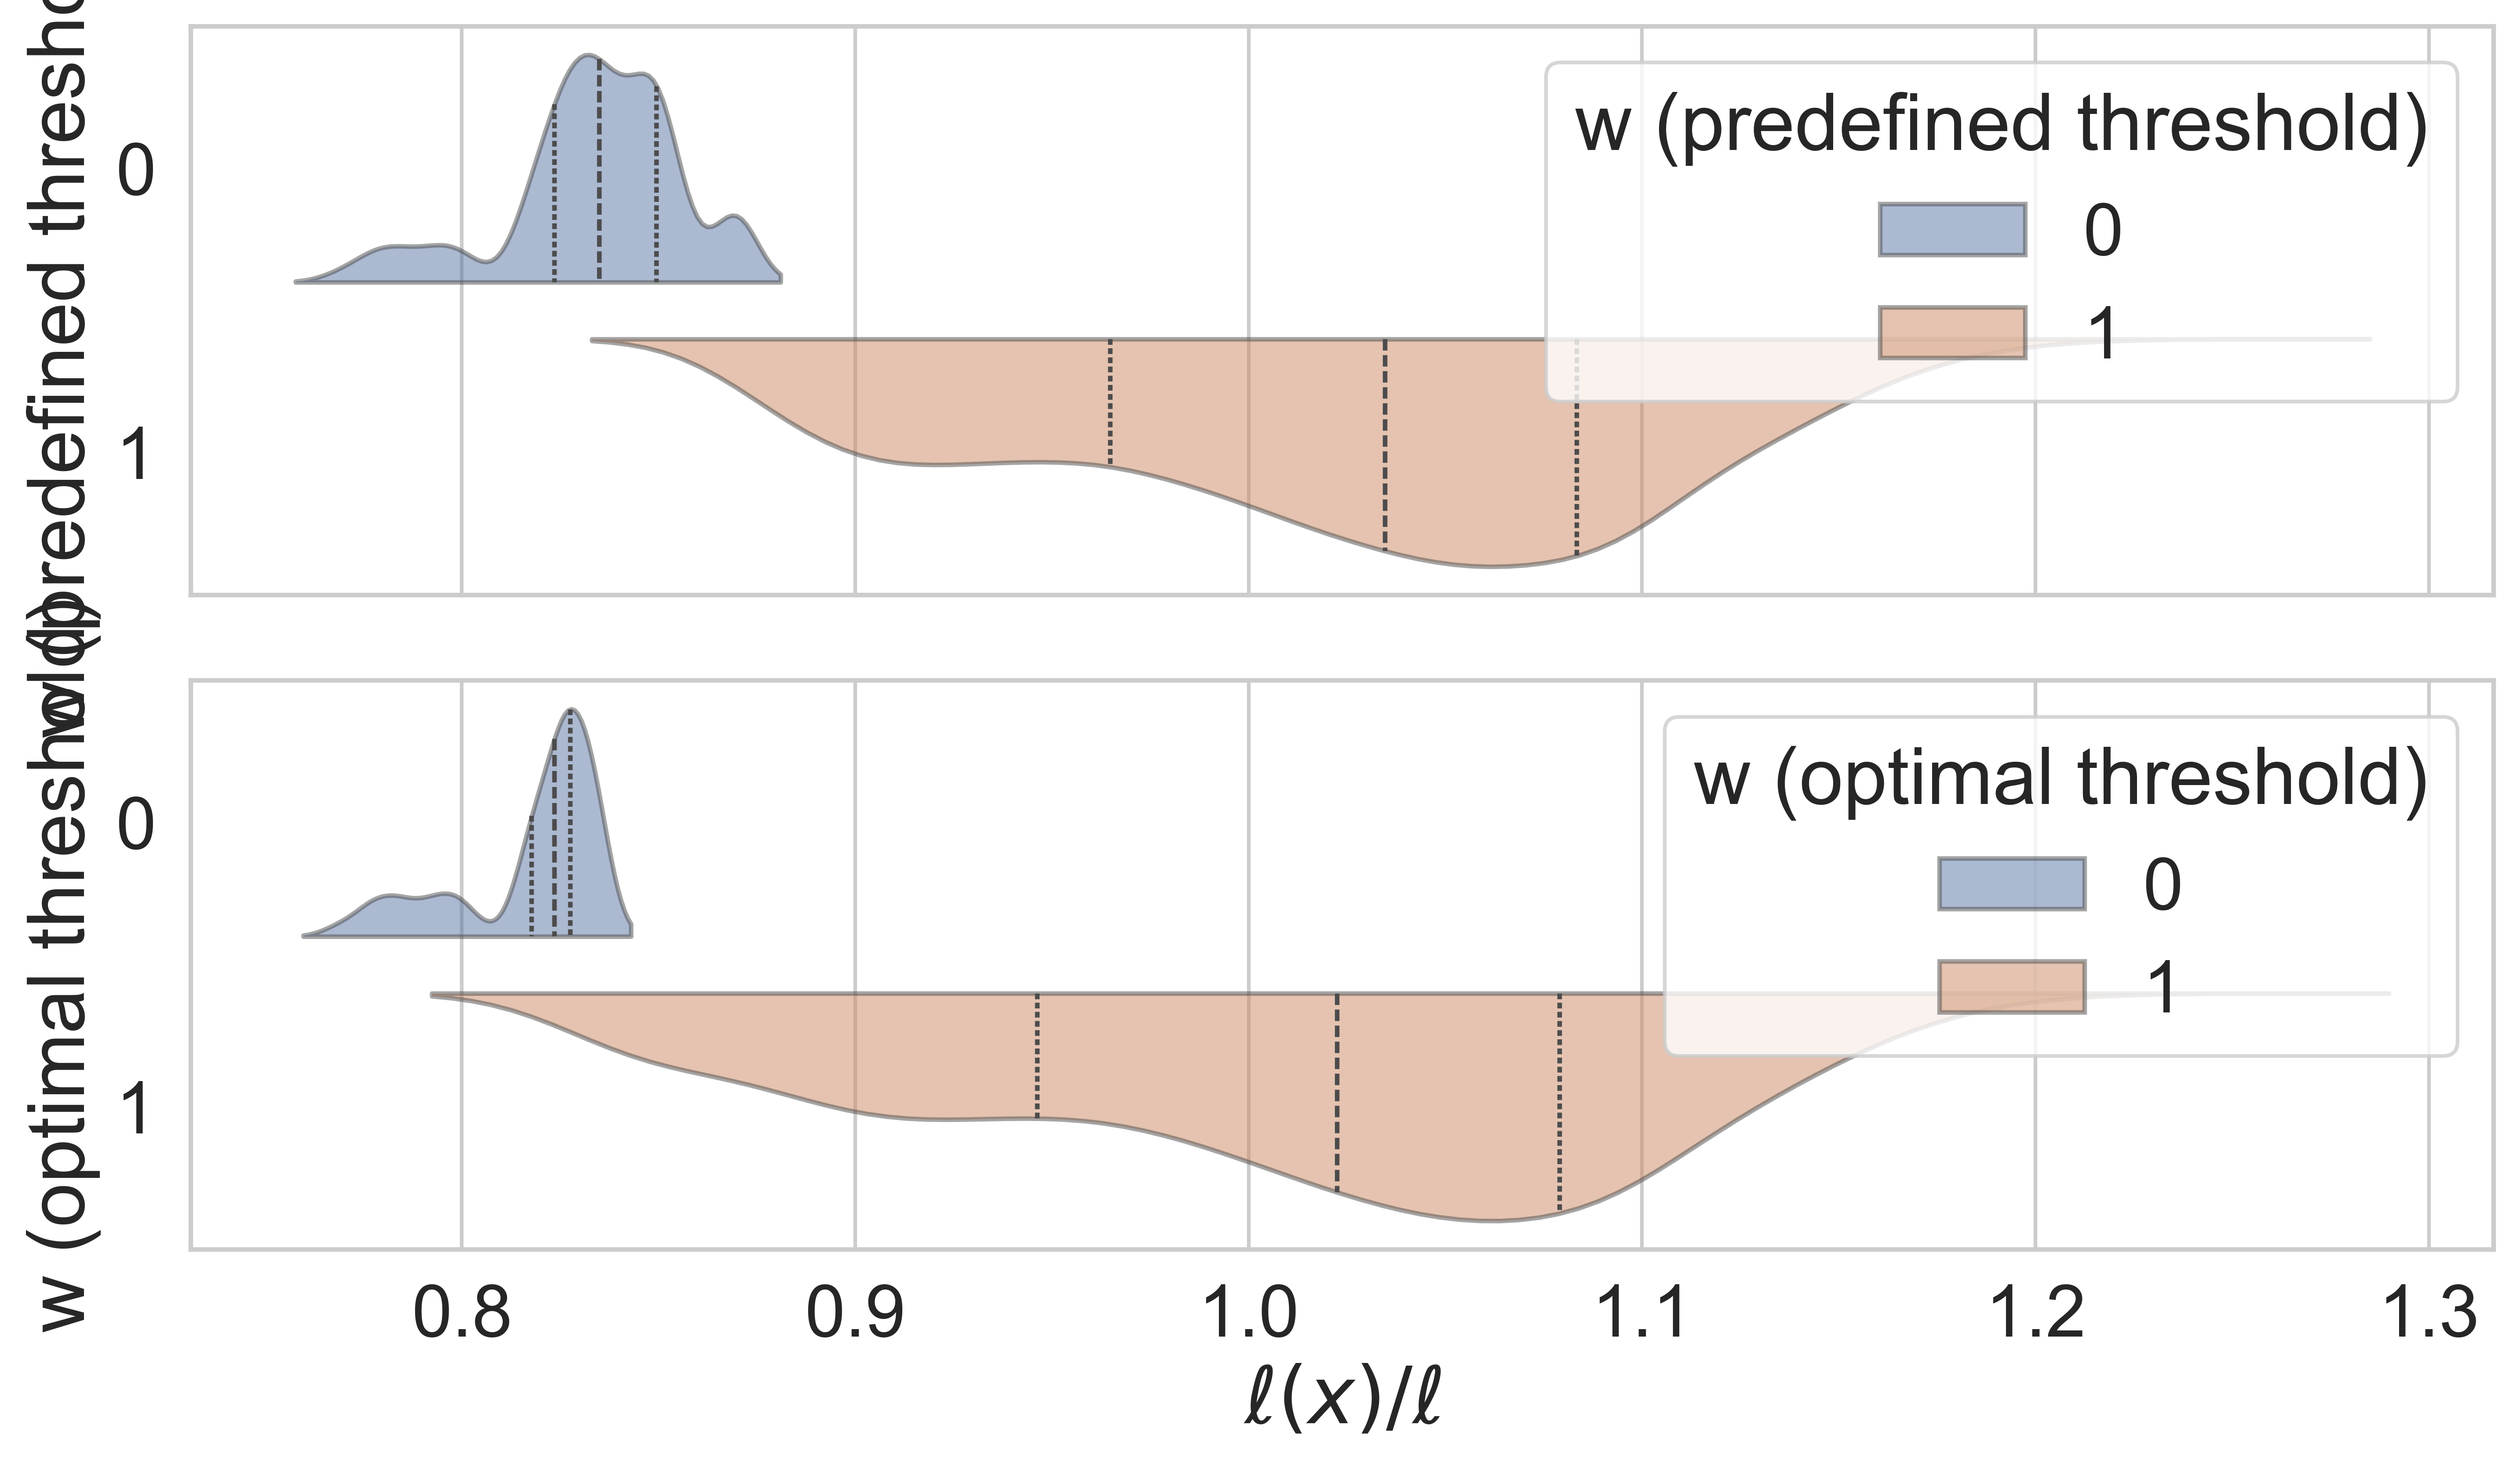

In [12]:
np.random.seed(42)
a_vals = np.linspace(0.83, 0.86, num=5000)


def obj(a):
    data_dummy_logit["w (optimal threshold)"] = (
        data_dummy_logit["pi(x)/pi"] > a
    ).astype(int)
    val = 100 * df_v["te"].loc[data_dummy_logit["w (optimal threshold)"] == 1].sem()
    return val


objs = [obj(a) for a in a_vals]

plt.axhline(100 * df_v["te"].sem())
sns.lineplot(x=a_vals, y=objs)


sns.set(font_scale=1.8, style="whitegrid")
fig, ax = plt.subplots(sharex=True, figsize=(10, 3), dpi=600)
sns.violinplot(
    data=data_dummy_logit,
    y="S",
    hue="S",
    x="pi(x)/pi",
    orient="h",
    split="True",
    inner="quart",
    alpha=0.5,
    bw=0.25,
)
plt.axvline(a_vals[np.argmin(objs)], c="red", ls="--")
plt.axvline(0.87, c="black", ls="--")
plt.xlabel(r"$\ell(x)/\overline{\ell}$")

data_dummy_logit["w (optimal threshold)"] = (
    data_dummy_logit["pi(x)/pi"] > a_vals[np.argmin(objs)]
).astype(int)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 6), dpi=600)
sns.set(font_scale=1.8, style="whitegrid")
sns.violinplot(
    data=data_dummy_logit,
    x="pi(x)/pi",
    y="w (predefined threshold)",
    hue="w (predefined threshold)",
    split=True,
    orient="h",
    ax=ax[0],
    alpha=0.5,
    inner="quart",
    bw=0.25,
)
sns.violinplot(
    data=data_dummy_logit,
    x="pi(x)/pi",
    y="w (optimal threshold)",
    hue="w (optimal threshold)",
    split=True,
    orient="h",
    ax=ax[1],
    alpha=0.5,
    inner="quart",
    bw=0.25,
)
plt.xlabel(r"$\ell(x)/{\ell}$")
plt.tight_layout()
plt.savefig("underrep_logit_opt.pdf")

a_vals[np.argmin(objs)], objs[np.argmin(objs)], data_dummy_logit[
    "w (optimal threshold)"
].loc[data_dummy_logit["S"] == 1].mean()

### Printing treatment effects 

In [13]:
print(
    r"Pre Pruning, ATTE: %.3f ± %.3f"
    % (
        100 * df_v["te"].mean(),
        100 * df_v["te"].sem(),
    )
)

print(
    r"Post Pruning (using predefined $\pi(x)$ threshold), ATTE: %.3f ± %.3f"
    % (
        100
        * df_v["te"]
        .loc[data_dummy_logit["w (predefined threshold)"].astype(int) == 1]
        .mean(),
        100
        * df_v["te"]
        .loc[data_dummy_logit["w (predefined threshold)"].astype(int) == 1]
        .sem(),
    )
)

print(
    r"Post Pruning (using optimal $\pi(x)$ threshold), ATTE: %.3f ± %.3f"
    % (
        100
        * df_v["te"]
        .loc[data_dummy_logit["w (optimal threshold)"].astype(int) == 1]
        .mean(),
        100
        * df_v["te"]
        .loc[data_dummy_logit["w (optimal threshold)"].astype(int) == 1]
        .sem(),
    )
)

Pre Pruning, ATTE: -9.721 ± 4.679
Post Pruning (using predefined $\pi(x)$ threshold), ATTE: -9.222 ± 4.750
Post Pruning (using optimal $\pi(x)$ threshold), ATTE: -10.169 ± 4.676


## Characterizing Underrepresented Population via Indicator $w(x)$
$w(x) = \sum_i w_i \mathbf{1}[x=X_i]$

(1271, 10)
(-0.2734865346380862, 0.046225495807829656, -0.09721208349623099, 0.04677517273692789)


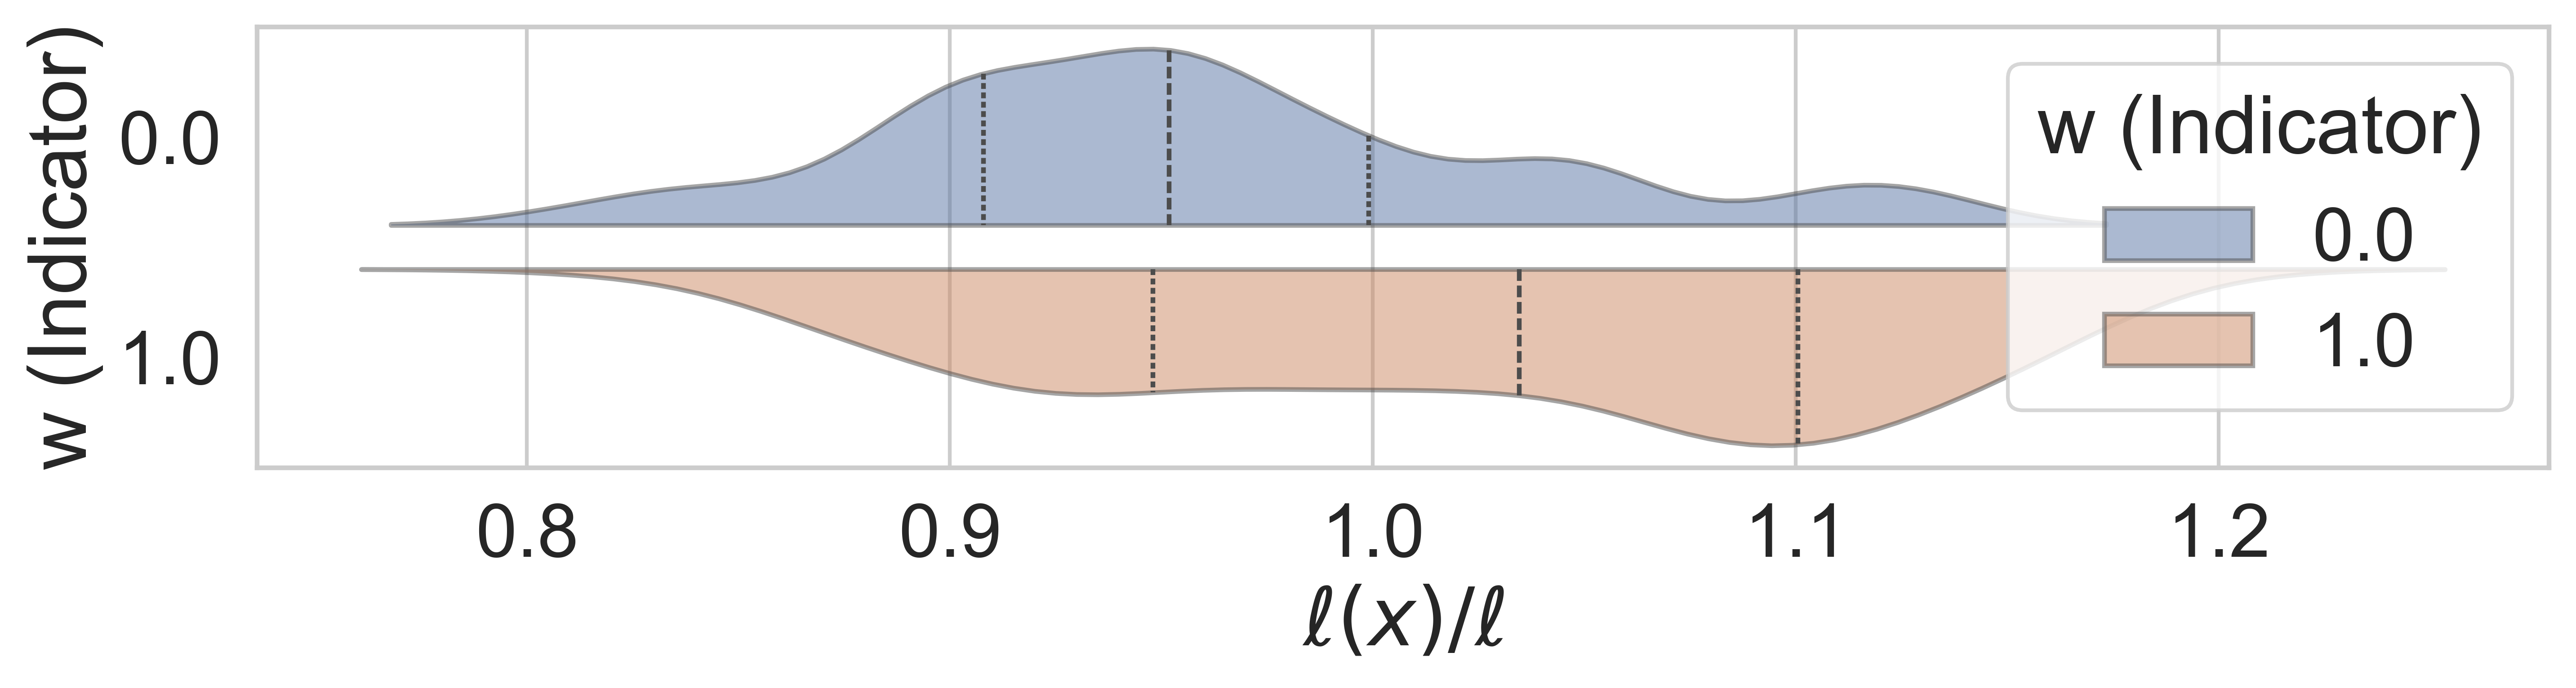

In [16]:
importlib.reload(learn)
# D, w_tree, testing_data = learn.tree_opt(data, outcome, treatment, sample, leaf_proba=1)
np.random.seed(42)
D_labels, f, testing_data = learn.kmeans_opt(
    data=data_dummy,
    outcome=outcome,
    k=400,
    treatment=treatment,
    sample=sample,
    threshold=1,
)


data_dummy_logit["w (Indicator)"] = D_labels["w"].astype(int)

fig, ax = plt.subplots(sharex=True, figsize=(10, 3), dpi=600)
sns.violinplot(
    data=data_dummy_logit,
    x="pi(x)/pi",
    y="w (Indicator)",
    hue="w (Indicator)",
    split=True,
    orient="h",
    ax=ax,
    alpha=0.5,
    inner="quart",
    bw=0.25,
)

plt.xlabel(r"$\ell(x)/{\ell}$")
plt.tight_layout()
plt.savefig("underrep_indicator.pdf")

In [17]:
print(
    r"Post Pruning (using optimal $\pi(x)$ threshold), ATTE: %.3f ± %.3f"
    % (
        100 * df_v["te"].loc[data_dummy_logit["w (Indicator)"] == 1].mean(),
        100 * df_v["te"].loc[data_dummy_logit["w (Indicator)"] == 1].sem(),
    )
)

Post Pruning (using optimal $\pi(x)$ threshold), ATTE: -27.349 ± 4.595


## Characterizing Underrepresented Population via ROOT

In [19]:
importlib.reload(learn)

np.random.seed(42)
D_rash, D_forest, w_forest, rashomon_set, f, testing_data = learn.forest_opt(
    data=data_dummy.drop(columns=["w"], errors="ignore"),
    outcome=outcome,
    treatment=treatment,
    sample=sample,
    leaf_proba=0.25,
    num_trees=5000,
    vote_threshold=9 / 10,
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((D_forest.shape[0] ** 2)))

ATE Estimate: -0.0972
leaf              0.200000
Age               0.007360
IV Drug Use       0.160407
Hx Amphetamine    0.098338
Male              0.039124
Hx Cannabis       0.099687
Hx Benzo          0.063554
White             0.113046
Black             0.151727
Hispanic          0.052719
Other Race        0.014038
dtype: float64


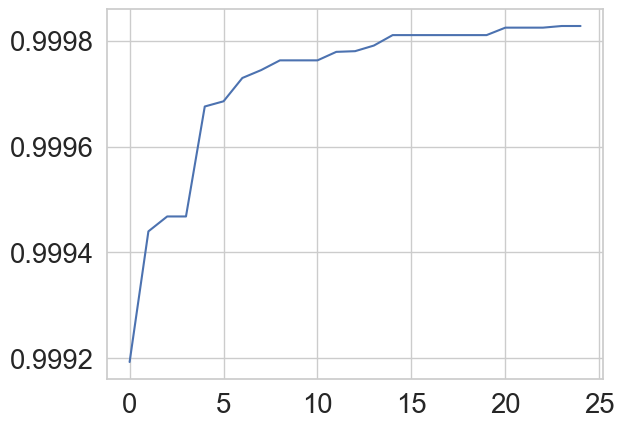

In [20]:
np.random.seed(42)

### Sorting trees by their objective values (smallest to largest)
local_obj = pd.DataFrame(
    np.array([w_forest[i]["local objective"] for i in range(len(w_forest))]),
    columns=["Objective"],
).sort_values(by="Objective")

### choosing top-k trees and plotting relative obj (Creating a Rashomon Set)
top_k = 25
plt.plot((local_obj.iloc[:top_k] / baseline_loss)["Objective"].values)

w_rash = ["w_tree_%d" % (i) for i in list(local_obj.iloc[:top_k].index)]

In [37]:
avg_votes = D_forest[w_rash].mean(axis=1)  # >= 1).astype(int)
D_rash["w_opt"] = avg_votes
print(
    r"Post Pruning, ATTE: %.3f ± %.3f"
    % (
        100 * D_rash["v"].loc[D_rash["w_opt"].astype(int) == 1].mean(),
        100 * D_rash["v"].loc[D_rash["w_opt"].astype(int) == 1].sem(),
    )
)

np.random.seed(42)
num_trees = 1
explainer = tree.DecisionTreeClassifier(max_leaf_nodes=8).fit(
    X.drop(columns=["Age"]).loc[avg_votes.index], avg_votes == 1
)

Post Pruning, ATTE: -12.483 ± 4.667


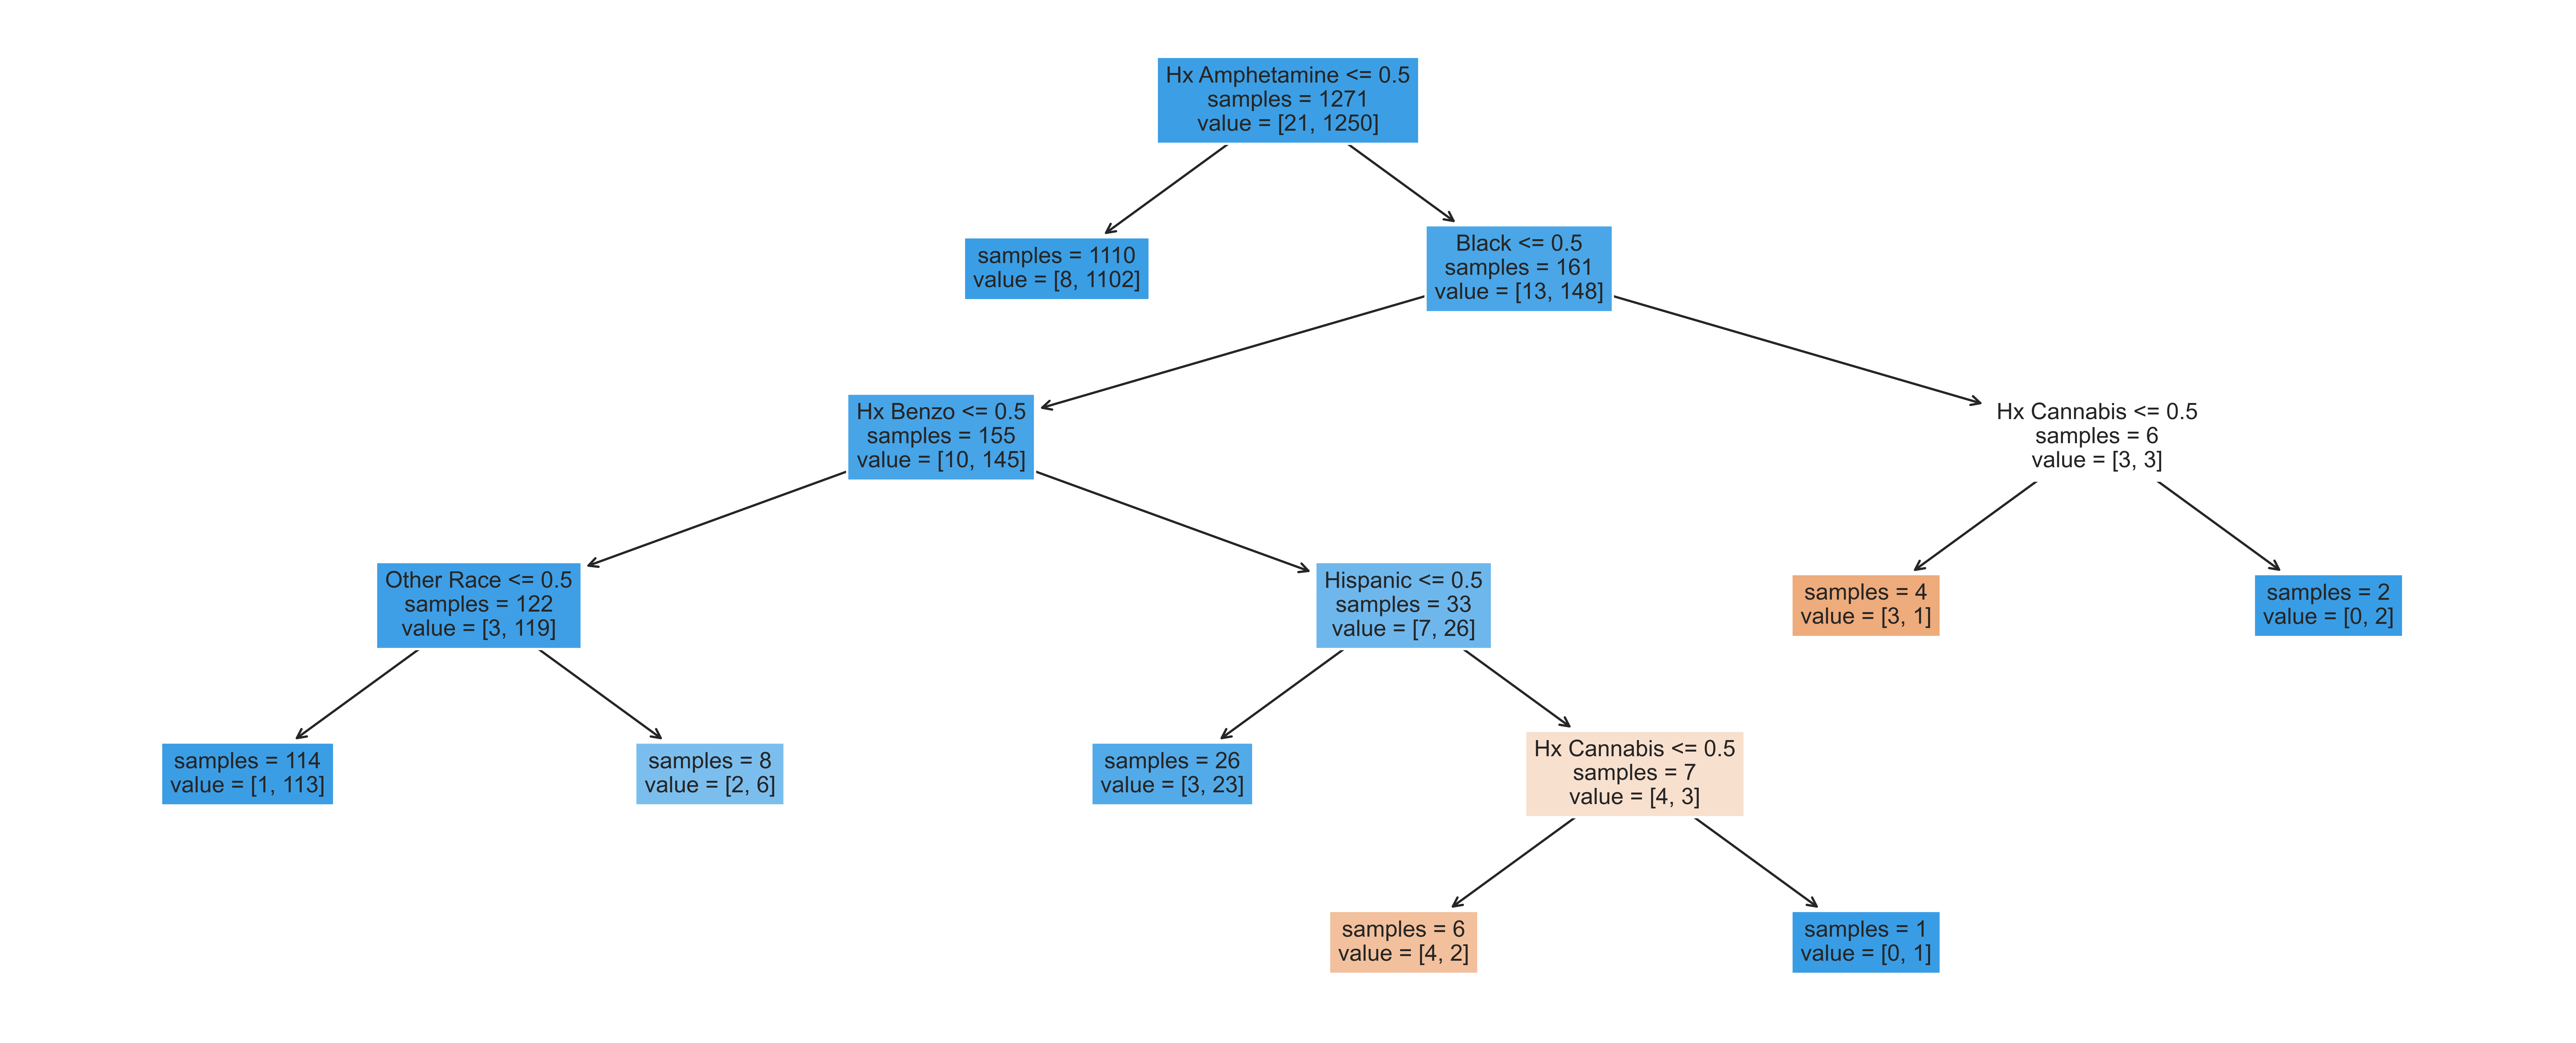

In [38]:
fig, ax = plt.subplots(nrows=num_trees, figsize=(20, 8), dpi=600)
for i in range(num_trees):
    if num_trees == 1:
        tree.plot_tree(
            explainer,  # .estimators_[i, 0],
            feature_names=[
                "IV Drug Use",
                "Hx Amphetamine",
                "Male",
                "Hx Cannabis",
                "Hx Benzo",
                "White",
                "Black",
                "Hispanic",
                "Other Race",
            ],
            ax=ax,
            filled=True,
            fontsize=10,
            # proportion=True,
            impurity=False,
        )
    else:
        tree.plot_tree(
            explainer.estimators_[i, 0],
            feature_names=[
                "IV Drug Use",
                "Hx Amphetamine",
                "Male",
                "Hx Cannabis",
                "Hx Benzo",
                "White",
                "Black",
                "Hispanic",
                "Other Race",
            ],
            ax=ax[i],
            filled=True,
            fontsize=10,
            # proportion=True,
        )
plt.savefig("tedsa_ctn27.pdf", dpi=600)

## Plotting All results in Selections Score Space

In [23]:
data_dummy_logit["w (ROOT)"] = D_rash["w_opt"].astype(int)
fig, ax = plt.subplots(
    nrows=2, ncols=2, sharex=True, sharey=True, figsize=(20, 8), dpi=600
)

sns.swarmplot(
    data=data_dummy_logit.loc[data_dummy_logit["S"] == 1].astype(float),
    x="pi(x)/pi",
    y="w (predefined threshold)",
    hue="w (predefined threshold)",
    # split=True,
    orient="h",
    ax=ax[0, 0],
    size=5,
    # alpha=0.5,
    # inner="quart",
    # fill=True,
    legend=False,
    hue_order=[1, 0],
)
sns.violinplot(
    data=data_dummy_logit.loc[data_dummy_logit["S"] == 1].astype(float),
    y="w (predefined threshold)",
    hue="w (predefined threshold)",
    x="pi(x)/pi",
    orient="h",
    # split=True,
    alpha=0.25,
    ax=ax[0, 0],
    inner="quart",
    fill=True,
    hue_order=[1, 0],
    legend=False,
)
ax[0, 0].set_ylabel("w")
ax[0, 0].axvline(0.87, ls="--", c="black")
ax[0, 0].set_title("(a) Predefined Defined Threshold on Selection Score")

sns.swarmplot(
    data=data_dummy_logit.loc[data_dummy_logit["S"] == 1].astype(float),
    x="pi(x)/pi",
    y="w (optimal threshold)",
    hue="w (optimal threshold)",
    # split=True,
    orient="h",
    ax=ax[0, 1],
    size=5,
    # alpha=0.5,
    # inner="quart",
    # fill=True,
    legend=False,
    hue_order=[1, 0],
)
sns.violinplot(
    data=data_dummy_logit.loc[data_dummy_logit["S"] == 1].astype(float),
    y="w (optimal threshold)",
    hue="w (optimal threshold)",
    x="pi(x)/pi",
    orient="h",
    # split=True,
    alpha=0.25,
    ax=ax[0, 1],
    inner="quart",
    fill=True,
    hue_order=[1, 0],
    legend=False,
)
ax[0, 1].set_ylabel("w")
ax[0, 1].axvline(a_vals[np.argmin(objs)], ls="--", c="black")
ax[0, 1].set_title("(b) Optimized Threshold on Selection Score")


sns.swarmplot(
    data=data_dummy_logit.loc[data_dummy_logit["S"] == 1].astype(float),
    y="w (Indicator)",
    hue="w (Indicator)",
    x="pi(x)/pi",
    orient="h",
    # split=True,
    # alpha=0.5,
    ax=ax[1, 0],
    size=5,
    # inner="quart",
    # fill=True,
    legend=False,
    hue_order=[1, 0],
)
sns.violinplot(
    data=data_dummy_logit.loc[data_dummy_logit["S"] == 1].astype(float),
    y="w (Indicator)",
    hue="w (Indicator)",
    x="pi(x)/pi",
    orient="h",
    # split=True,
    alpha=0.25,
    ax=ax[1, 0],
    inner="quart",
    fill=True,
    legend=False,
    hue_order=[1, 0],
)
ax[1, 0].set_title("(c) Indicator")
ax[1, 0].set_ylabel("w")


sns.swarmplot(
    data=data_dummy_logit.loc[data_dummy_logit["S"] == 1].astype(float),
    y="w (ROOT)",
    hue="w (ROOT)",
    x="pi(x)/pi",
    orient="h",
    # split=True,
    # alpha=0.5,
    ax=ax[1, 1],
    size=5,
    # inner="quart",
    # fill=True,
    legend=False,
    hue_order=[1, 0],
)
sns.violinplot(
    data=data_dummy_logit.loc[data_dummy_logit["S"] == 1].astype(float),
    y="w (ROOT)",
    hue="w (ROOT)",
    x="pi(x)/pi",
    orient="h",
    # split=True,
    alpha=0.25,
    ax=ax[1, 1],
    inner="quart",
    fill=True,
    hue_order=[1, 0],
)
ax[1, 1].set_title("(d) ROOT")
ax[1, 1].legend(title="w")
ax[1, 1].set_ylabel("w")


# plt.ylabel("w")
# plt.legend(title="w")
plt.xlabel(r"$\ell(x)/\ell$")
plt.tight_layout()
plt.savefig("underrep_root.pdf")

# print(
#     (
#         D_rash.loc[D_rash["w_opt"] == 1]["v"].mean(),
#         D_rash.loc[D_rash["w_opt"] == 0]["v"].mean(),
#     )
# )

In [24]:
### Percentage of covariate space marked as underrepresented
data_dummy_logit.mean()

S                           0.001715
med_met                     0.000714
opioiduse24                 0.001215
pi(x)                       0.001715
pi(x)/pi                    1.000282
w (predefined threshold)    0.874397
w (optimal threshold)       0.938017
w (Indicator)               0.895358
w (ROOT)                    0.983478
dtype: float64